Layer 0: Block_0, Precision: 8 bits
Layer 1: Block_1, Precision: 8 bits
Layer 2: Block_2, Precision: 8 bits
Layer 3: Block_3, Precision: 8 bits
Layer 4: Block_4, Precision: 8 bits
Layer 5: Block_5, Precision: 8 bits
Layer 6: Block_6, Precision: 4 bits
Layer 7: Block_7, Precision: 4 bits
Layer 8: Block_8, Precision: 4 bits
Layer 9: Block_9, Precision: 4 bits
Layer 10: Block_10, Precision: 4 bits
Layer 11: Block_11, Precision: 4 bits
Layer 12: Block_12, Precision: 4 bits
Layer 13: Block_13, Precision: 4 bits
Layer 14: Block_14, Precision: 4 bits
Layer 15: Block_15, Precision: 4 bits
Layer 16: Block_16, Precision: 4 bits
Layer 17: Block_17, Precision: 4 bits
Layer 18: Block_18, Precision: 4 bits
Layer 19: Block_19, Precision: 4 bits
Layer 20: Block_20, Precision: 4 bits
Layer 21: Block_21, Precision: 4 bits
Layer 22: Block_22, Precision: 4 bits
Layer 23: Block_23, Precision: 4 bits
Layer 24: Block_24, Precision: 4 bits
Layer 25: Block_25, Precision: 4 bits
Layer 26: Block_26, Precision: 2

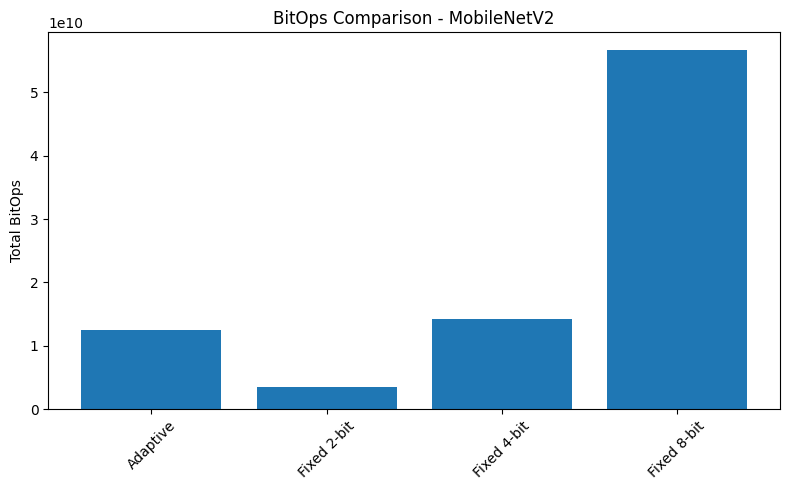

In [2]:
# MobileNetV2 Quantization Trade-Off Analysis

# This script compares fixed 2-bit, 4-bit, 8-bit, and adaptive precision quantization
# by calculating BitOps and MACs for MobileNetV2.

# Useful for hardware-efficiency analysis.

import math
import torch
import torchvision.models as models
from tabulate import tabulate
import matplotlib.pyplot as plt
import csv
import os



def compute_output_dim(input_dim, stride):                       # Compute output dimension after convolution
    return math.ceil(input_dim / stride)


def get_variable_precision(layer_idx, total_layers):             # Assign precision based on layer index (Adaptive Quantization)
    if layer_idx < 0.1 * total_layers:
        return 8  # High precision for early layers
    elif layer_idx < 0.5 * total_layers:
        return 4  # Medium precision
    else:
        return 2  # Low precision for later layers



# ----------------------------
# Define a block abstraction to store layer-wise computation details
# ----------------------------
'''
 MobileNetBlock represents a single layer in the MobileNet architecture.
 It stores critical information like input/output channels, stride, kernel size, and precision.
 It also calculates the output dimensions, number of MACs (multiply-accumulate operations),
 parameters, and bit operations for the layer based on its type (standard or depthwise separable).
'''
class MobileNetBlock:
    def __init__(self, name, block_type, in_ch, out_ch, stride, precision,
                 input_h, input_w, kernel_size):
        self.name = name
        self.block_type = block_type
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.precision = precision
        self.input_h = input_h
        self.input_w = input_w
        self.kernel_size = kernel_size

        self.out_h = compute_output_dim(input_h, stride)
        self.out_w = compute_output_dim(input_w, stride)

        # MACs and parameter count depending on block type
        if block_type == "standard":
            self.macs = self.out_h * self.out_w * (kernel_size ** 2) * in_ch * out_ch
            self.params = (kernel_size ** 2) * in_ch * out_ch
        elif block_type == "depthwise_separable":
            self.macs = (self.out_h * self.out_w * (kernel_size ** 2) * in_ch +
                         self.out_h * self.out_w * in_ch * out_ch)
            self.params = (kernel_size ** 2) * in_ch + in_ch * out_ch
        else:
            raise ValueError("Invalid block type")

    def get_bitops(self):
        return self.macs * (self.precision ** 2)

    def summary(self):
        return {
            "Block Name": self.name,
            "Type": self.block_type,
            "In_Ch": self.in_ch,
            "Out_Ch": self.out_ch,
            "Stride": self.stride,
            "Input Size": f"{self.input_h}x{self.input_w}",
            "Output Size": f"{self.out_h}x{self.out_w}",
            "MACs": self.macs,
            "Params": self.params,
            "Precision": self.precision,
            "BitOps": self.get_bitops()
        }



# ----------------------------
# Extract all Conv2D layers and assign quantization levels
# ----------------------------
'''
 This function extracts all Conv2D layers from the given model, assigns a quantization
 level to each layer (based on the specified precision type), and determines if each
 layer is a standard convolution or depthwise separable convolution.
 It calculates and stores the block details such as MACs, parameters, precision for each layer.
'''
def extract_blocks(model, input_size=(224, 224), precision_type="variable"):
    blocks = []
    height, width = input_size
    conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]                        # Extract Conv2D layers
    total_layers = len(conv_layers)

    for i, layer in enumerate(conv_layers):
        in_ch, out_ch = layer.in_channels, layer.out_channels                                           # Get input and output channels
        stride = layer.stride[0]
        k = layer.kernel_size[0]                                                                        # Get kernel size


        precision = get_variable_precision(i, total_layers) if precision_type == "variable" else precision_type

        block_type = "depthwise_separable" if layer.groups == in_ch and in_ch == out_ch else "standard"

        block = MobileNetBlock(f"Block_{i}", block_type, in_ch, out_ch, stride, precision, height, width, k)

        blocks.append(block)

        height = compute_output_dim(height, stride)

        width = compute_output_dim(width, stride)

        print(f"Layer {i}: {block.name}, Precision: {precision} bits")

    return blocks


# ----------------------------
# Tabulate and export architecture summary
# ----------------------------
'''
 This function generates a table summary of the model architecture, including details
 of each layer such as its type, input/output channels, stride, MACs, parameters,
 precision, and BitOps. It also calculates and prints the total values for MACs,
 BitOps, and parameters across all layers, and optionally exports the summary to a CSV file.
'''
def summarize_architecture(blocks, title, csv_path=None):
    # Define the headers for the summary table
    headers = ["Block Name", "Type", "In_Ch", "Out_Ch", "Stride", "Input Size", "Output Size",
               "MACs", "Params", "Precision", "BitOps"]


    rows, total_macs, total_params, total_bitops = [], 0, 0, 0                # Initialize variables to store total MACs, parameters, and BitOps

    for block in blocks:
        s = block.summary()                                                   # Summary of the layer
        rows.append([s[h] for h in headers])
        total_macs += s["MACs"]                                               # Total MACs
        total_params += s["Params"]                                           # Total parameters
        total_bitops += s["BitOps"]                                           # Total BitOps


    print(f"\n{title}")                                                       # Print the summary table with block-wise details
    print(tabulate(rows, headers=headers, tablefmt="grid"))

    print("\nTotal Stats:")                                                    # Print the total statistics (MACs, BitOps, Parameters)
    print(tabulate([
        ["Total MACs", total_macs],
        ["Total BitOps", total_bitops],
        ["Total Parameters", total_params]
    ], tablefmt="grid"))

    if csv_path:
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(headers)
            writer.writerows(rows)
            writer.writerow([])
            writer.writerow(["Total MACs", total_macs])
            writer.writerow(["Total BitOps", total_bitops])
            writer.writerow(["Total Parameters", total_params])

    return {"MACs": total_macs, "BitOps": total_bitops, "Params": total_params}



# Visualization for BitOps

def plot_bitops(results_dict, model_name):
    labels = list(results_dict.keys())
    bitops = [v["BitOps"] for v in results_dict.values()]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, bitops)
    plt.title(f"BitOps Comparison - {model_name}")
    plt.ylabel("Total BitOps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"results/bitops_comparison_{model_name.lower().replace(' ', '_')}.png")
    plt.show()




def main():
    os.makedirs("results", exist_ok=True)

    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    results = {}

    # Run for all 4 precision, adaptive and fixed (2, 4, 8 bits)
    for precision in ["variable", 2, 4, 8]:
        label = f"Adaptive" if precision == "variable" else f"Fixed {precision}-bit"
        blocks = extract_blocks(model, precision_type=precision)
        csv_path = os.path.join("results", f"mobilenetv2_{label.replace(' ', '_').lower()}.csv")
        results[label] = summarize_architecture(blocks, title=label, csv_path=csv_path)

    plot_bitops(results, "MobileNetV2")

if __name__ == "__main__":
    main()
